# Módulo # 4 - Big Data

## Tarea # 3 
## Autor: Jose Martinez

# Datos de Entrada

## Abandono de Banco

Este conjunto de datos contiene detalles de los clientes de un banco y la variable objetivo es una variable binaria que refleja el hecho de si el cliente dejó el banco (cerró su cuenta) o si continúa siendo un cliente.

### Features

- `RowNumber`: Número de fila (Int)
- `CustomerId`: Identificador del cliente (Int)
- `Surname`: apellido del cliente (String)
- `CreditScore`: puntaje de crédito del cliente (Number)
- `Geography`: geografía del cliente (String)
- `Gender`: Sexo del cliente (String)
- `Age`: Edad del cliente (Int)
- `Tenure`: Número de años que el cliente ha estado en el banco (Int)
- `Balance`: estado de cuenta del cliente (Float)
- `NumOfProducts`: numero de productos del cliente (Int)
- `HasCrCard`: tiene tarjeta de crédito (Bool)
- `IsActiveMember`: es un miembro activo (Bool)
- `EstimatedSalary`: salario estimado del cliente (Float)

### Objetivo Predictivo

- `Exited`: si el cliente abandonó el banco (Bool)

In [1]:
import findspark
findspark.init('/usr/lib/python3.7/site-packages/pyspark')

from pyspark.sql.types import (StringType, IntegerType, FloatType, 
                                StructField, StructType)

from pyspark.sql import SparkSession

spark = SparkSession \
    .builder \
    .appName("Bigdata: Tarea 3") \
    .config("spark.driver.extraClassPath", "postgresql-42.2.14.jar") \
    .config("spark.executor.extraClassPath", "postgresql-42.2.14.jar") \
    .getOrCreate()

# Define the schema of the dataframe
churn_df = spark \
    .read \
    .format("csv") \
    .option("path", "churn_modelling.csv") \
    .option("header", True) \
    .schema(StructType([
                StructField("RowNumber", IntegerType()),
                StructField("CustomerId", IntegerType()),
                StructField("Surname", StringType()),
                StructField("CreditScore", IntegerType()),
                StructField("Geography", StringType()),
                StructField("Gender", StringType()),
                StructField("Age", IntegerType()),
                StructField("Tenure", IntegerType()),
                StructField("Balance", FloatType()),
                StructField("NumOfProducts", IntegerType()),
                StructField("HasCrCard", IntegerType()),
                StructField("IsActiveMember", IntegerType()),
                StructField("EstimatedSalary", FloatType()),
                StructField("Exited", IntegerType())])) \
    .load()

# Print the schema of the dataframe
churn_df.printSchema()
churn_df.show()

Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
21/11/03 21:22:56 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


root
 |-- RowNumber: integer (nullable = true)
 |-- CustomerId: integer (nullable = true)
 |-- Surname: string (nullable = true)
 |-- CreditScore: integer (nullable = true)
 |-- Geography: string (nullable = true)
 |-- Gender: string (nullable = true)
 |-- Age: integer (nullable = true)
 |-- Tenure: integer (nullable = true)
 |-- Balance: float (nullable = true)
 |-- NumOfProducts: integer (nullable = true)
 |-- HasCrCard: integer (nullable = true)
 |-- IsActiveMember: integer (nullable = true)
 |-- EstimatedSalary: float (nullable = true)
 |-- Exited: integer (nullable = true)

+---------+----------+---------+-----------+---------+------+---+------+---------+-------------+---------+--------------+---------------+------+
|RowNumber|CustomerId|  Surname|CreditScore|Geography|Gender|Age|Tenure|  Balance|NumOfProducts|HasCrCard|IsActiveMember|EstimatedSalary|Exited|
+---------+----------+---------+-----------+---------+------+---+------+---------+-------------+---------+--------------+---

# Preprocesamiento de datos

In [2]:
from pyspark.sql.functions import when

# Se hace un primer filtrado para eliminar los registros que no tienen
# información valiosa para calcular el modelo. Como lo son los registros
# RowNumber, CustomerId, Surname. 

columns_kept = ['CreditScore', 'Gender', 'Age', 'Tenure', 'Geography',
                'Balance', 'NumOfProducts', 'HasCrCard',
                'IsActiveMember', 'EstimatedSalary', 'Exited']

columns_features = ['CreditScore', 'Gender', 'Age', 'Tenure', 'Geography',
                    'Balance', 'NumOfProducts', 'HasCrCard',
                    'IsActiveMember', 'EstimatedSalary']

selected_columns_df = churn_df.select(columns_kept)

# Change Gender to int
selected_columns_df = selected_columns_df.withColumn('Gender',
                                                     when(selected_columns_df.Gender == 'Male', 1)
                                                     .when(selected_columns_df.Gender == 'Female', 0)
                                                     .otherwise(selected_columns_df.Gender))
selected_columns_df = selected_columns_df .withColumn('Gender', selected_columns_df['Gender'].cast(IntegerType()))

# Change Geography to int
selected_columns_df = selected_columns_df.withColumn('Geography',
                                                     when(selected_columns_df.Geography == 'Spain', 0)
                                                     .when(selected_columns_df.Geography == 'France', 1)
                                                     .when(selected_columns_df.Geography == 'Germany', 2)
                                                     .otherwise(selected_columns_df.Geography))
selected_columns_df = selected_columns_df .withColumn('Geography', selected_columns_df['Geography'].cast(IntegerType()))

selected_columns_df.show()

+-----------+------+---+------+---------+---------+-------------+---------+--------------+---------------+------+
|CreditScore|Gender|Age|Tenure|Geography|  Balance|NumOfProducts|HasCrCard|IsActiveMember|EstimatedSalary|Exited|
+-----------+------+---+------+---------+---------+-------------+---------+--------------+---------------+------+
|        619|     0| 42|     2|        1|      0.0|            1|        1|             1|      101348.88|     1|
|        608|     0| 41|     1|        0| 83807.86|            1|        0|             1|      112542.58|     0|
|        502|     0| 42|     8|        1| 159660.8|            3|        1|             0|      113931.57|     1|
|        699|     0| 39|     1|        1|      0.0|            2|        0|             0|       93826.63|     0|
|        850|     0| 43|     2|        0|125510.82|            1|        1|             1|        79084.1|     0|
|        645|     1| 44|     8|        0|113755.78|            2|        1|             

## Gráficos y Estadísticas Descriptivas

In [3]:
# Imprimimos información de los datos para verificar que no hay ningún
# problema con los datos.
selected_columns_df.describe(['CreditScore', 'Gender', 'Age', 'Tenure']).show()
selected_columns_df.describe(['Balance', 'NumOfProducts', 'HasCrCard', 'Geography']).show()
selected_columns_df.describe(['IsActiveMember', 'EstimatedSalary', 'Exited']).show()

+-------+-----------------+------------------+------------------+------------------+
|summary|      CreditScore|            Gender|               Age|            Tenure|
+-------+-----------------+------------------+------------------+------------------+
|  count|            10000|             10000|             10000|             10000|
|   mean|         650.5288|            0.5457|           38.9218|            5.0128|
| stddev|96.65329873613035|0.4979320271185253|10.487806451704587|2.8921743770496837|
|    min|              350|                 0|                18|                 0|
|    max|              850|                 1|                92|                10|
+-------+-----------------+------------------+------------------+------------------+

+-------+------------------+------------------+-------------------+------------------+
|summary|           Balance|     NumOfProducts|          HasCrCard|         Geography|
+-------+------------------+------------------+-------------

## Histogramas

Text(0.5, 1.0, 'Exited')

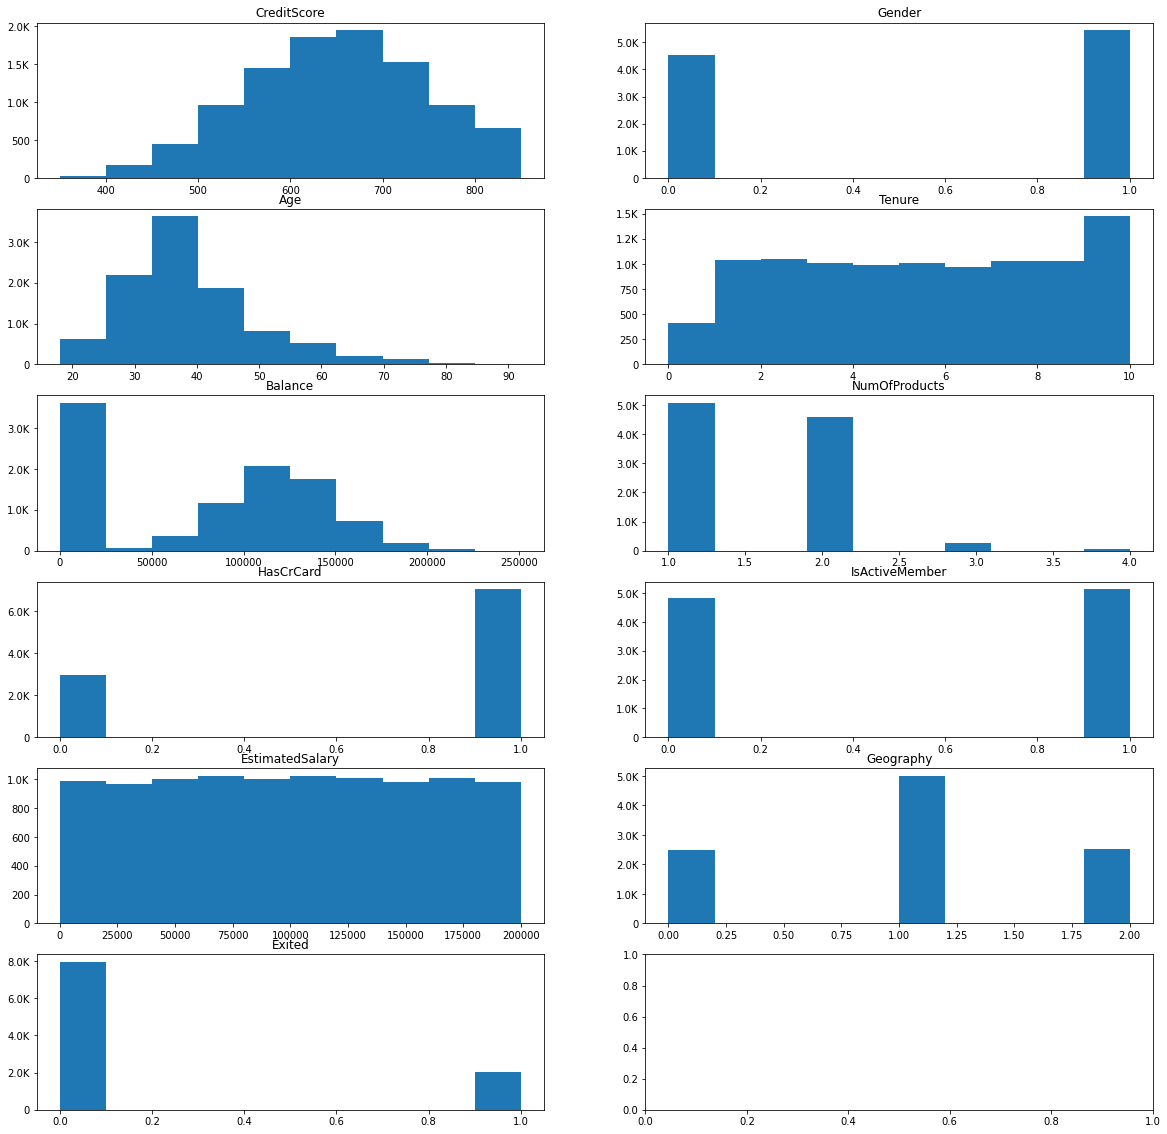

In [4]:
from pyspark_dist_explore import hist
import matplotlib.pyplot as plt

fig, ax = plt.subplots(nrows=6, ncols=2)
fig.set_size_inches(20, 20)

hist(ax[0, 0], selected_columns_df.select('CreditScore'))
ax[0, 0].set_title('CreditScore')

hist(ax[0, 1], selected_columns_df.select('Gender'))
ax[0, 1].set_title('Gender')

hist(ax[1, 0], selected_columns_df.select('Age'))
ax[1, 0].set_title('Age')

hist(ax[1, 1], selected_columns_df.select('Tenure'))
ax[1, 1].set_title('Tenure')

hist(ax[2, 0], selected_columns_df.select('Balance'))
ax[2, 0].set_title('Balance')

hist(ax[2, 1], selected_columns_df.select('NumOfProducts'))
ax[2, 1].set_title('NumOfProducts')

hist(ax[3, 0], selected_columns_df.select('HasCrCard'))
ax[3, 0].set_title('HasCrCard')

hist(ax[3, 1], selected_columns_df.select('IsActiveMember'))
ax[3, 1].set_title('IsActiveMember')

hist(ax[4, 0], selected_columns_df.select('EstimatedSalary'))
ax[4, 0].set_title('EstimatedSalary')

hist(ax[4, 1], selected_columns_df.select('Geography'))
ax[4, 1].set_title('Geography')

hist(ax[5, 0], selected_columns_df.select('Exited'))
ax[5, 0].set_title('Exited')

## Oversampling

Como se observa en el histograma de la variable objetivo, la cantidad de datos no es balanceada y hay muchos mas casos de abandono de cuenta que de no abandono. Por lo que se va a aplicar oversampling para mejorar la balanceación de los datos.

In [5]:
from pyspark.sql.functions import explode, array, lit
from pyspark_dist_explore import hist
import matplotlib.pyplot as plt

selected_columns_df.groupby("Exited").count().show()

major_df = selected_columns_df.filter(selected_columns_df.Exited == 0)
minor_df = selected_columns_df.filter(selected_columns_df.Exited == 1)
ratio = int(major_df.count()/minor_df.count())
print("ratio: {}".format(ratio))

a = range(ratio)

# Duplicate the minority rows
oversampled_df = minor_df.withColumn("dummy", explode(array([lit(x) for x in a]))).drop('dummy')

# Combine both oversampled minority rows and previous majority rows 
combined_df = major_df.unionAll(oversampled_df)

combined_df.groupby("Exited").count().show()

+------+-----+
|Exited|count|
+------+-----+
|     1| 2037|
|     0| 7963|
+------+-----+

ratio: 3
+------+-----+
|Exited|count|
+------+-----+
|     0| 7963|
|     1| 6111|
+------+-----+



## Matriz de Correlaciones

+--------------------+------+
|            Features|Exited|
+--------------------+------+
|[608.0,0.0,41.0,1...|     0|
|[699.0,0.0,39.0,1...|     0|
|[850.0,0.0,43.0,2...|     0|
|[822.0,1.0,50.0,7...|     0|
|[501.0,1.0,44.0,4...|     0|
|[684.0,1.0,27.0,2...|     0|
|[528.0,1.0,31.0,6...|     0|
|[497.0,1.0,24.0,3...|     0|
|[476.0,0.0,34.0,1...|     0|
|[549.0,0.0,25.0,5...|     0|
|[635.0,0.0,35.0,7...|     0|
|[616.0,1.0,45.0,3...|     0|
|[549.0,0.0,24.0,9...|     0|
|[587.0,1.0,45.0,6...|     0|
|[726.0,0.0,24.0,6...|     0|
|[732.0,1.0,41.0,8...|     0|
|[636.0,0.0,32.0,8...|     0|
|[669.0,1.0,46.0,3...|     0|
|[846.0,0.0,38.0,5...|     0|
|[577.0,1.0,25.0,3...|     0|
+--------------------+------+
only showing top 20 rows



21/11/03 21:23:23 WARN InstanceBuilder$NativeBLAS: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
21/11/03 21:23:23 WARN InstanceBuilder$NativeBLAS: Failed to load implementation from:dev.ludovic.netlib.blas.ForeignLinkerBLAS
/usr/lib/python3.7/site-packages/pyspark/sql/context.py:127: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  FutureWarning


<AxesSubplot:>

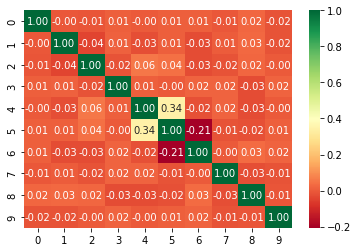

In [6]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.stat import Correlation
import matplotlib.pyplot as plt
import seaborn as sns

# Para realizar operaciones más detalladas es necesario expresar las filas originales en vectores
assembler = VectorAssembler(
    inputCols=columns_features,
    outputCol='Features')

vector_df = assembler.transform(combined_df)
vector_df = vector_df.select(['Features', 'Exited'])
vector_df.show()

# Con la representación de vectores podemos calcular correlaciones
pearson_matrix = Correlation.corr(vector_df, 'Features').collect()[0][0]
sns.heatmap(pearson_matrix.toArray(), annot=True, fmt=".2f", cmap='RdYlGn')

## Imputacion de valores faltantes

El dataset fue revisando previamente para ver si existen valores faltantes. En este se cuanta con la fortuna de que no existen valores faltantes, por lo que no es necesario realizar ninguna acción. 

## Normalización / Estandarización de Datos

In [7]:
from pyspark.ml.feature import StandardScaler, Normalizer

# standard_normalizer = Normalizer(inputCol='features', outputCol='normFeatures')
# normalize_df = standard_normalizer.transform(vector_df)
# normalize_df.show()

standard_scaler = StandardScaler(inputCol='Features', outputCol='scaledFeatures')
scale_model = standard_scaler.fit(vector_df)

scaled_df = scale_model.transform(vector_df)
scaled_df = scaled_df.select(['scaledFeatures', 'Exited'])
scaled_df.printSchema()
scaled_df.show()

root
 |-- scaledFeatures: vector (nullable = true)
 |-- Exited: integer (nullable = true)

+--------------------+------+
|      scaledFeatures|Exited|
+--------------------+------+
|[6.21993245924743...|     0|
|[7.15087629772032...|     0|
|[8.69562926046105...|     0|
|[8.40918500246939...|     0|
|[5.12530618763645...|     0|
|[6.99742401665336...|     0|
|[5.40152029355698...|     0|
|[5.08438557935193...|     0|
|[4.86955238585819...|     0|
|[5.61635348705073...|     0|
|[6.49614656516796...|     0|
|[6.30177367581648...|     0|
|[5.61635348705073...|     0|
|[6.00509926575369...|     0|
|[7.42709040364085...|     0|
|[7.48847131606763...|     0|
|[6.50637671723909...|     0|
|[6.84397173558640...|     0|
|[8.65470865217653...|     0|
|[5.90279774504238...|     0|
+--------------------+------+
only showing top 20 rows



## Escritura a base de datos.

In [8]:
from pyspark.ml.functions import vector_to_array
from pyspark.sql.functions import col


# Covertir vector a columnas
pre_df = (scaled_df.withColumn("scaledFeatures", vector_to_array("scaledFeatures"))).select(["Exited"] + [col("scaledFeatures")[i].alias(columns_features[i]) for i in range(len(columns_features))])
pre_df.printSchema()
pre_df.show()

# Almacenar el conjunto de datos limpio en la base de datos
pre_df \
    .write \
    .format("jdbc") \
    .mode('overwrite') \
    .option("url", "jdbc:postgresql://172.17.0.1:5433/postgres") \
    .option("user", "postgres") \
    .option("password", "testPassword") \
    .option("dbtable", "tarea3") \
    .save()

root
 |-- Exited: integer (nullable = true)
 |-- CreditScore: double (nullable = true)
 |-- Gender: double (nullable = true)
 |-- Age: double (nullable = true)
 |-- Tenure: double (nullable = true)
 |-- Geography: double (nullable = true)
 |-- Balance: double (nullable = true)
 |-- NumOfProducts: double (nullable = true)
 |-- HasCrCard: double (nullable = true)
 |-- IsActiveMember: double (nullable = true)
 |-- EstimatedSalary: double (nullable = true)

+------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+-----------------+-----------------+-------------------+
|Exited|       CreditScore|            Gender|               Age|            Tenure|         Geography|           Balance|     NumOfProducts|        HasCrCard|   IsActiveMember|    EstimatedSalary|
+------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+-----

# Entrenamiento del modelo

In [9]:
# Reading single DataFrame in Spark by retrieving all rows from a DB table.
df = spark \
    .read \
    .format("jdbc") \
    .option("url", "jdbc:postgresql://172.17.0.1:5433/postgres") \
    .option("user", "postgres") \
    .option("password", "testPassword") \
    .option("dbtable", "tarea3") \
    .load()

df.show()

assembler = VectorAssembler(
    inputCols=columns_features,
    outputCol='Features')

vector_df = assembler.transform(selected_columns_df)
vector_df = vector_df.select(['Features', 'Exited'])
vector_df.show()

+------+-----------------+------------------+------------------+------------------+------------------+------------------+------------------+-----------------+-----------------+-------------------+
|Exited|      CreditScore|            Gender|               Age|            Tenure|         Geography|           Balance|     NumOfProducts|        HasCrCard|   IsActiveMember|    EstimatedSalary|
+------+-----------------+------------------+------------------+------------------+------------------+------------------+------------------+-----------------+-----------------+-------------------+
|     1|6.332464132029875|               0.0|3.9523781581720097|0.6884737043985172|1.3799206766052852|               0.0|1.5305297556168111|2.189770661136184|2.003432721123733| 1.7587238837149326|
|     1|6.332464132029875|               0.0|3.9523781581720097|0.6884737043985172|1.3799206766052852|               0.0|1.5305297556168111|2.189770661136184|2.003432721123733| 1.7587238837149326|
|     1|6.33246

## Dividir dataset en conjunto de entrenamiento y prueba

In [10]:
# Split the data into training and test sets (70 % training, 30 % test)
training_df, test_df = scaled_df.randomSplit([0.7, 0.3])

# Imprimir tamano de los conjuntos de datos
print(scaled_df.count())
print(training_df.count())
print(test_df.count())

14074
9877
4197


## Uso de protocolo K-fold cross validation

In [11]:
# Codigo tomado de https://stackoverflow.com/questions/53600615/cross-validation-metrics-with-pyspark
from pyspark.ml.tuning import CrossValidator, CrossValidatorModel
from pyspark.mllib.evaluation import BinaryClassificationMetrics
from pyspark.sql.functions import rand
import numpy as np
import collections

TestResult = collections.namedtuple("TestResult", ["params", "metrics"])

class CrossValidatorVerbose(CrossValidator):

    def _fit(self, dataset):
        folds = []
        est = self.getOrDefault(self.estimator)
        epm = self.getOrDefault(self.estimatorParamMaps)
        numModels = len(epm)

        eva = self.getOrDefault(self.evaluator)
        metricName = eva.getMetricName()
        nFolds = self.getOrDefault(self.numFolds)
        seed = self.getOrDefault(self.seed)
        h = 1.0 / nFolds

        randCol = self.uid + "_rand"
        df = dataset.select("*", rand(seed).alias(randCol))
        metrics = [0.0] * numModels

        for i in range(nFolds):
            folds.append([])
            foldNum = i + 1
            print("Comparing models on fold %d" % foldNum)

            validateLB = i * h
            validateUB = (i + 1) * h
            condition = (df[randCol] >= validateLB) & (df[randCol] < validateUB)
            validation = df.filter(condition)
            train = df.filter(~condition)

            for j in range(numModels):
                paramMap = epm[j]
                model = est.fit(train, paramMap)
                # TODO: duplicate evaluator to take extra params from input
                prediction = model.transform(validation, paramMap)
                metric = eva.evaluate(prediction)
                metrics[j] += metric

                avgSoFar = metrics[j] / foldNum
                print("params: %s\t%s: %f\tavg: %f" % (
                    {param.name: val for (param, val) in paramMap.items()},
                    metricName, metric, avgSoFar))
                
                predictionLabels = prediction.select("prediction", "Exited")
                allMetrics = BinaryClassificationMetrics(predictionLabels.rdd)
                folds[i].append(TestResult(paramMap.items(), allMetrics))
                

        if eva.isLargerBetter():
            bestIndex = np.argmax(metrics)
        else:
            bestIndex = np.argmin(metrics)

        bestParams = epm[bestIndex]
        bestModel = est.fit(dataset, bestParams)
        avgMetrics = [m / nFolds for m in metrics]
        bestAvg = avgMetrics[bestIndex]
        print("Best model:\nparams: %s\t%s: %f" % (
            {param.name: val for (param, val) in bestParams.items()},
            metricName, bestAvg))

        return self._copyValues(CrossValidatorModel(bestModel, avgMetrics)), folds

## Modelo 1: Regresión Logística 

In [12]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.tuning import ParamGridBuilder

df = training_df.select('scaledFeatures', 'Exited')
df.show()

lr = LogisticRegression(featuresCol='scaledFeatures', labelCol='Exited', maxIter=10)
grid = ParamGridBuilder().addGrid(param=lr.maxIter, values=[10]).build()

# Implementa k-Folds e imprime informacion por cada iteracion
cv = CrossValidatorVerbose(estimator=lr,
                           estimatorParamMaps=grid,
                           evaluator=BinaryClassificationEvaluator(labelCol='Exited'),
                           numFolds=5)

cvlr_model, lr_folds = cv.fit(df)

+--------------------+------+
|      scaledFeatures|Exited|
+--------------------+------+
|(10,[0,1,2,6,9],[...|     0|
|(10,[0,1,2,6,9],[...|     0|
|(10,[0,2,3,6,9],[...|     0|
|(10,[0,2,3,6,9],[...|     0|
|(10,[0,2,3,6,9],[...|     0|
|(10,[0,2,3,6,9],[...|     0|
|(10,[0,2,3,6,9],[...|     0|
|(10,[0,2,3,6,9],[...|     0|
|(10,[0,2,3,6,9],[...|     0|
|(10,[0,2,3,6,9],[...|     0|
|(10,[0,2,3,6,9],[...|     0|
|(10,[0,2,3,6,9],[...|     0|
|(10,[0,2,3,6,9],[...|     0|
|(10,[0,2,3,6,9],[...|     0|
|(10,[0,2,3,6,9],[...|     0|
|(10,[0,2,3,6,9],[...|     0|
|(10,[0,2,3,6,9],[...|     0|
|(10,[0,2,3,6,9],[...|     0|
|(10,[0,2,3,6,9],[...|     0|
|(10,[0,2,3,6,9],[...|     0|
+--------------------+------+
only showing top 20 rows

Comparing models on fold 1


params: {'maxIter': 10}	areaUnderROC: 0.752572	avg: 0.752572
Comparing models on fold 2


params: {'maxIter': 10}	areaUnderROC: 0.772068	avg: 0.762320
Comparing models on fold 3


params: {'maxIter': 10}	areaUnderROC: 0.778107	avg: 0.767582
Comparing models on fold 4


params: {'maxIter': 10}	areaUnderROC: 0.780993	avg: 0.770935
Comparing models on fold 5


params: {'maxIter': 10}	areaUnderROC: 0.759289	avg: 0.768606


Best model:
params: {'maxIter': 10}	areaUnderROC: 0.768606


## Modelo 2: Random Forest

In [13]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.tuning import ParamGridBuilder

df = training_df.select('scaledFeatures', 'Exited')
df.show()

rf = RandomForestClassifier(featuresCol='scaledFeatures', labelCol='Exited', maxDepth=4)
grid = ParamGridBuilder().addGrid(rf.maxDepth, values=[4]).build()

# Implementa k-Folds e imprime informacion por cada iteracion
cv = CrossValidatorVerbose(estimator=rf,
                           estimatorParamMaps=grid,
                           evaluator=BinaryClassificationEvaluator(labelCol='Exited'),
                           numFolds=5)

cvrf_model, rf_folds = cv.fit(df)

+--------------------+------+
|      scaledFeatures|Exited|
+--------------------+------+
|(10,[0,1,2,6,9],[...|     0|
|(10,[0,1,2,6,9],[...|     0|
|(10,[0,2,3,6,9],[...|     0|
|(10,[0,2,3,6,9],[...|     0|
|(10,[0,2,3,6,9],[...|     0|
|(10,[0,2,3,6,9],[...|     0|
|(10,[0,2,3,6,9],[...|     0|
|(10,[0,2,3,6,9],[...|     0|
|(10,[0,2,3,6,9],[...|     0|
|(10,[0,2,3,6,9],[...|     0|
|(10,[0,2,3,6,9],[...|     0|
|(10,[0,2,3,6,9],[...|     0|
|(10,[0,2,3,6,9],[...|     0|
|(10,[0,2,3,6,9],[...|     0|
|(10,[0,2,3,6,9],[...|     0|
|(10,[0,2,3,6,9],[...|     0|
|(10,[0,2,3,6,9],[...|     0|
|(10,[0,2,3,6,9],[...|     0|
|(10,[0,2,3,6,9],[...|     0|
|(10,[0,2,3,6,9],[...|     0|
+--------------------+------+
only showing top 20 rows

Comparing models on fold 1
params: {'maxDepth': 4}	areaUnderROC: 0.823172	avg: 0.823172
Comparing models on fold 2
params: {'maxDepth': 4}	areaUnderROC: 0.838866	avg: 0.831019
Comparing models on fold 3
params: {'maxDepth': 4}	areaUnderROC: 0.855573	avg:

## Model 3: Decision Tree

In [14]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.tuning import ParamGridBuilder

df = training_df.select('scaledFeatures', 'Exited')
df.show()

dt = DecisionTreeClassifier(featuresCol='scaledFeatures', labelCol='Exited', maxDepth = 4)
grid = ParamGridBuilder().addGrid(dt.maxDepth, values=[4]).build()

# Implementa k-Folds e imprime informacion por cada iteracion
cv = CrossValidatorVerbose(estimator=dt,
                           estimatorParamMaps=grid,
                           evaluator=BinaryClassificationEvaluator(labelCol='Exited'),
                           numFolds=5)

cvdt_model, dt_folds = cv.fit(df)

+--------------------+------+
|      scaledFeatures|Exited|
+--------------------+------+
|(10,[0,1,2,6,9],[...|     0|
|(10,[0,1,2,6,9],[...|     0|
|(10,[0,2,3,6,9],[...|     0|
|(10,[0,2,3,6,9],[...|     0|
|(10,[0,2,3,6,9],[...|     0|
|(10,[0,2,3,6,9],[...|     0|
|(10,[0,2,3,6,9],[...|     0|
|(10,[0,2,3,6,9],[...|     0|
|(10,[0,2,3,6,9],[...|     0|
|(10,[0,2,3,6,9],[...|     0|
|(10,[0,2,3,6,9],[...|     0|
|(10,[0,2,3,6,9],[...|     0|
|(10,[0,2,3,6,9],[...|     0|
|(10,[0,2,3,6,9],[...|     0|
|(10,[0,2,3,6,9],[...|     0|
|(10,[0,2,3,6,9],[...|     0|
|(10,[0,2,3,6,9],[...|     0|
|(10,[0,2,3,6,9],[...|     0|
|(10,[0,2,3,6,9],[...|     0|
|(10,[0,2,3,6,9],[...|     0|
+--------------------+------+
only showing top 20 rows

Comparing models on fold 1
params: {'maxDepth': 4}	areaUnderROC: 0.664980	avg: 0.664980
Comparing models on fold 2
params: {'maxDepth': 4}	areaUnderROC: 0.645564	avg: 0.655272
Comparing models on fold 3
params: {'maxDepth': 4}	areaUnderROC: 0.690391	avg:

# Evaluación del conjunto de validación

In [15]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator
from pyspark.mllib.evaluation import BinaryClassificationMetrics
import matplotlib.pyplot as plt
import numpy as np

def display_metrics(model):
    # Make predictions on the test set
    predictions = model.transform(test_df.select('scaledFeatures', 'Exited'))

    # Evaluate the model
    evaluator = BinaryClassificationEvaluator(labelCol='Exited')
    auroc = evaluator.evaluate(predictions, {evaluator.metricName: "areaUnderROC"})
    auprc = evaluator.evaluate(predictions, {evaluator.metricName: "areaUnderPR"})
    print("Area under ROC Curve: {:.5f}".format(auroc))
    print("Area under PR Curve: {:.5f}".format(auprc))
    
    evaluator = MulticlassClassificationEvaluator(labelCol='Exited', metricName="accuracy")
    acc = evaluator.evaluate(predictions)
    print("Accuracy: {:.5f}".format(acc))

    return auroc, auprc, acc
    
def save_model(model_name, model):
    
    predictions = model.transform(test_df.select('scaledFeatures', 'Exited'))
    
    pre_df = (predictions.withColumn("scaledFeatures", vector_to_array("scaledFeatures"))).select(["prediction"] + ["Exited"] + [col("scaledFeatures")[i].alias(columns_features[i]) for i in range(len(columns_features))])    
    pre_df.printSchema()
    
    pre_df \
        .write \
        .format("jdbc") \
        .mode('overwrite') \
        .option("url", "jdbc:postgresql://172.17.0.1:5433/postgres") \
        .option("user", "postgres") \
        .option("password", "testPassword") \
        .option("dbtable", model_name) \
        .save()

## Evaluación y almacenado de modelo 1

Pesos: [-0.053849625232375,-0.2676287377490143,0.8349209435548324,-0.04819933321148136,0.2841071618335499,0.22048830566993,-0.06007775363258871,-0.008039666790305731,-0.48869446283421447,0.012758411033233916]
 b: -2.893638247952581


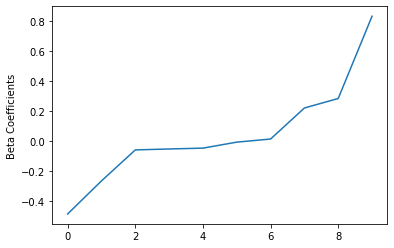

/usr/lib/python3.7/site-packages/pyspark/sql/context.py:127: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  FutureWarning


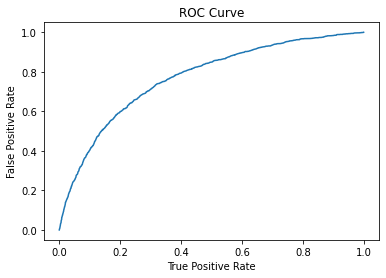

/usr/lib/python3.7/site-packages/pyspark/sql/context.py:127: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  FutureWarning


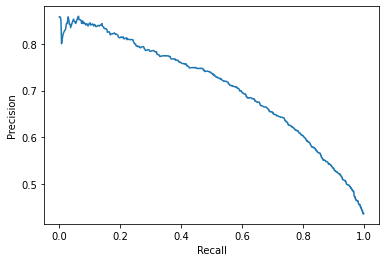

Area under ROC Curve: 0.75755
Area under PR Curve: 0.67929
Accuracy: 0.70241
root
 |-- prediction: double (nullable = false)
 |-- Exited: integer (nullable = true)
 |-- CreditScore: double (nullable = true)
 |-- Gender: double (nullable = true)
 |-- Age: double (nullable = true)
 |-- Tenure: double (nullable = true)
 |-- Geography: double (nullable = true)
 |-- Balance: double (nullable = true)
 |-- NumOfProducts: double (nullable = true)
 |-- HasCrCard: double (nullable = true)
 |-- IsActiveMember: double (nullable = true)
 |-- EstimatedSalary: double (nullable = true)



In [16]:
# Crea graficas y analisis de los resultados

# Weights
print('Pesos: {}\n b: {}'.format(cvlr_model.bestModel.coefficients, cvlr_model.bestModel.intercept))

# Coefficients 
beta = np.sort(cvlr_model.bestModel.coefficients)
plt.plot(beta)
plt.ylabel('Beta Coefficients')
plt.show()

# Area under ROC
trainingSummary = cvlr_model.bestModel.summary
roc = trainingSummary.roc.toPandas()
plt.plot(roc['FPR'],roc['TPR'])
plt.ylabel('False Positive Rate')
plt.xlabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

# Precision and recall.
pr = trainingSummary.pr.toPandas()
plt.plot(pr['recall'],pr['precision'])
plt.ylabel('Precision')
plt.xlabel('Recall')
plt.show()
    
cvlr_auroc, cvlr_auprc, cvlr_acc = display_metrics(cvlr_model)

# Guardar modelo en base de datos
save_model("modelo1", cvlr_model)

## Evaluación y almacenado de modelo 2

/usr/lib/python3.7/site-packages/pyspark/sql/context.py:127: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  FutureWarning


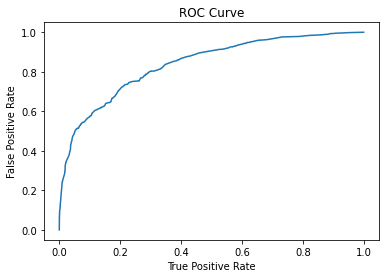

/usr/lib/python3.7/site-packages/pyspark/sql/context.py:127: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  FutureWarning


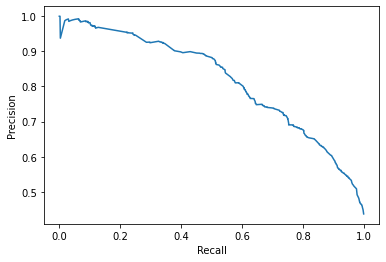

Area under ROC Curve: 0.83502
Area under PR Curve: 0.81061
Accuracy: 0.74744
root
 |-- prediction: double (nullable = false)
 |-- Exited: integer (nullable = true)
 |-- CreditScore: double (nullable = true)
 |-- Gender: double (nullable = true)
 |-- Age: double (nullable = true)
 |-- Tenure: double (nullable = true)
 |-- Geography: double (nullable = true)
 |-- Balance: double (nullable = true)
 |-- NumOfProducts: double (nullable = true)
 |-- HasCrCard: double (nullable = true)
 |-- IsActiveMember: double (nullable = true)
 |-- EstimatedSalary: double (nullable = true)



In [17]:
# Area under ROC
trainingSummary = cvrf_model.bestModel.summary
roc = trainingSummary.roc.toPandas()
plt.plot(roc['FPR'],roc['TPR'])
plt.ylabel('False Positive Rate')
plt.xlabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

# Precision and recall.
pr = trainingSummary.pr.toPandas()
plt.plot(pr['recall'],pr['precision'])
plt.ylabel('Precision')
plt.xlabel('Recall')
plt.show()

# Crea graficas y analisis de los resultados
cvrf_auroc, cvrf_auprc, cvrf_acc = display_metrics(cvrf_model)

# Guardar modelo en base de datos
save_model("modelo2", cvrf_model)

## Evaluación y almacenado de modelo 3

In [18]:
# Crea graficas y analisis de los resultados
cvdt_auroc, cvdt_auprc, cvdt_acc = display_metrics(cvdt_model)

# Guardar modelo en base de datos
save_model("modelo3", cvdt_model)

Area under ROC Curve: 0.61900
Area under PR Curve: 0.62007
Accuracy: 0.74458
root
 |-- prediction: double (nullable = false)
 |-- Exited: integer (nullable = true)
 |-- CreditScore: double (nullable = true)
 |-- Gender: double (nullable = true)
 |-- Age: double (nullable = true)
 |-- Tenure: double (nullable = true)
 |-- Geography: double (nullable = true)
 |-- Balance: double (nullable = true)
 |-- NumOfProducts: double (nullable = true)
 |-- HasCrCard: double (nullable = true)
 |-- IsActiveMember: double (nullable = true)
 |-- EstimatedSalary: double (nullable = true)



## Analisis de resultados

Text(0, 0.5, 'Area under ROC Curve')

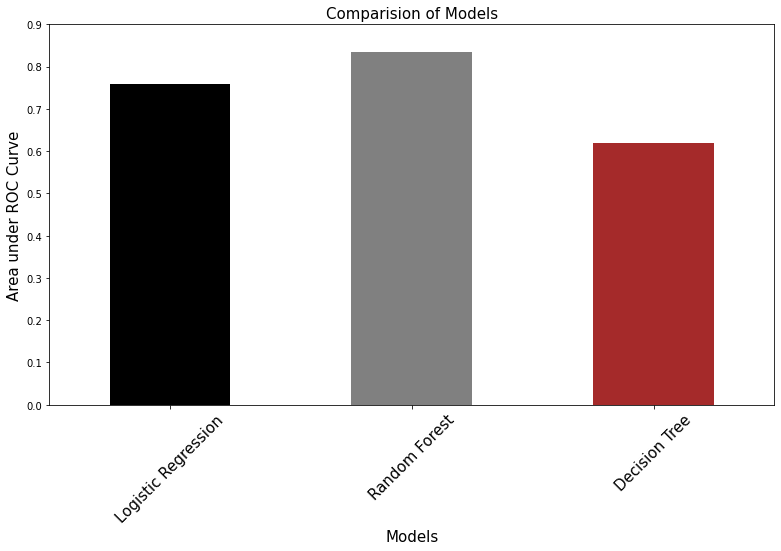

In [19]:
import pandas as pd 

names = ['Logistic Regression','Random Forest','Decision Tree']

results = pd.Series([cvlr_auroc , cvrf_auroc, cvdt_auroc])
ax = results.plot(kind = 'bar',figsize=(13,7),color=['black','gray','brown'])
ax.set_title('Comparision of Models',fontsize=15)
ax.set_yticks([0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9])
ax.set_xticklabels(names ,fontsize=15,rotation = 45)
ax.set_xlabel("Models",fontsize=15)
ax.set_ylabel("Area under ROC Curve",fontsize=15)

Text(0, 0.5, 'Area under PR Curve')

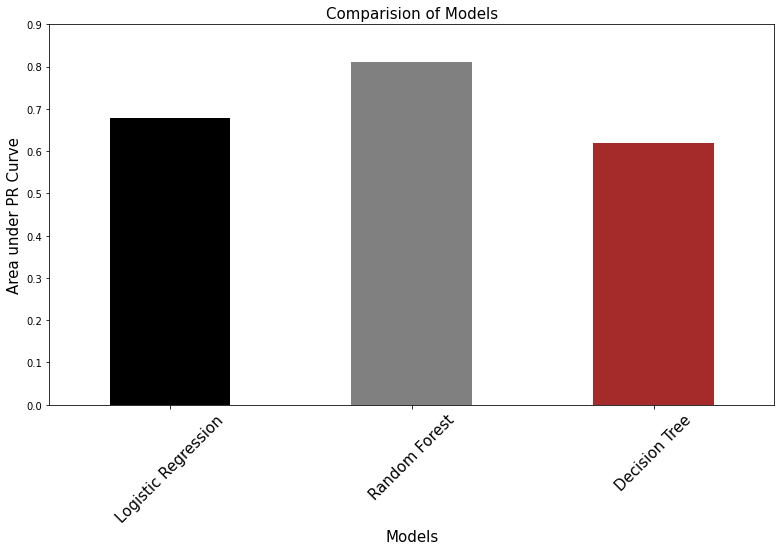

In [20]:
import pandas as pd 

names = ['Logistic Regression','Random Forest','Decision Tree']

results = pd.Series([cvlr_auprc , cvrf_auprc, cvdt_auprc])
ax = results.plot(kind = 'bar',figsize=(13,7),color=['black','gray','brown'])
ax.set_title('Comparision of Models',fontsize=15)
ax.set_yticks([0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9])
ax.set_xticklabels(names ,fontsize=15,rotation = 45)
ax.set_xlabel("Models",fontsize=15)
ax.set_ylabel("Area under PR Curve",fontsize=15)

Text(0, 0.5, 'Accuracy')

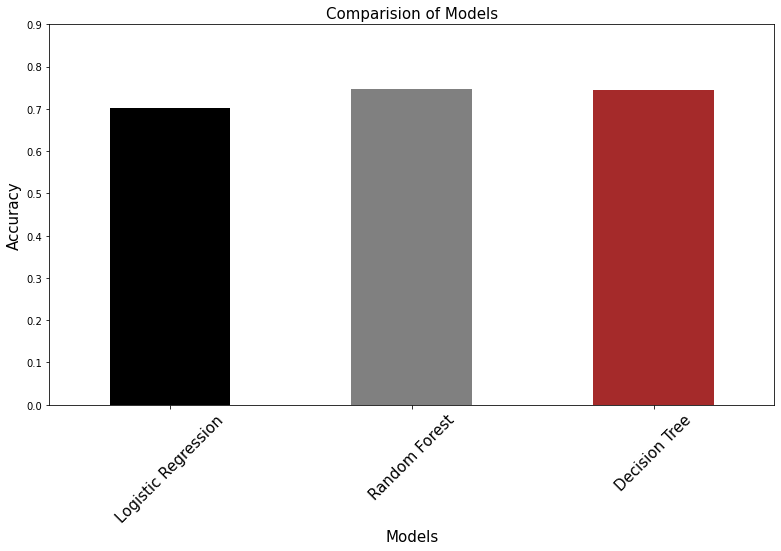

In [21]:
import pandas as pd 

names = ['Logistic Regression','Random Forest','Decision Tree']

results = pd.Series([cvlr_acc , cvrf_acc, cvdt_acc])
ax = results.plot(kind = 'bar',figsize=(13,7),color=['black','gray','brown'])
ax.set_title('Comparision of Models',fontsize=15)
ax.set_yticks([0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9])
ax.set_xticklabels(names ,fontsize=15,rotation = 45)
ax.set_xlabel("Models",fontsize=15)
ax.set_ylabel("Accuracy",fontsize=15)

# Modelo 1
En el primer modelo se utilizó una regresión logística para predecir el valor de la variable objetivo. Si se analizan los pesos se puede el feature 'CreditScore' tiene un peso muy alto, por lo que se puede decir que es una variable importante para predecir el valor de la variable objetivo. La grafica de precision-recall tipica de un modelo de regresión logística. 

# Modelo 2
En el segundo modelo se utilizó un Random Forest para predecir el valor de la variable objetivo. Con este modelo se obtuvieron los mejores resultados. En este casio la grafica de precision-recall del modelo 2 muestra que el modelo 2 tiene una precision de 0.9 y un recall de 0.9.

# Modelo 3 
Se creo un modelo adicional, just for fun :). En el tercer modelo se utilizó un Decision Tree para predecir el valor de la variable objetivo. Con este modelo se obtuvieron los peores resultados.

# Conclusiones

Al realizar la comparacion de los modelos, se puede observar que el modelo 3 es el mejor, el modelo 1 es el segundo mejor y el modelo 3 es el tercero mejor. Para este caso el modelo de Random Forest dio los mejores resultados. En todos los casos se realizo un modelo de k-fold cross validation, para obtener una mejor precisión. En la iteracion de los folds, se esta imprimiendo el AUROC y es interesante observar cambia el valor de AUROC en cada iteración. 